# Ratio Put-Spread Strategy

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

#### __Defining the universe__
The entire execution pipeline is handled via the DataManager class, so we just add methods to the pipline which get executed once the pipeline is populated. Due to the volume of data to be processed, options chains are pulled in in parallel, processed and then deleted from memory. Necessary data are retained in the model and used for later inference. 

In [2]:
import options_wizard as ow
import pandas as pd

universe = ow.Universe()
universe.top_constituents(10)
universe.check_ticks()
data_manager = ow.DataManager(universe, load_lazy=True)
len(data_manager.universe.ticks)

C:\Users\cameronA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\exchange_calendars\exchange_calendar.py:2346: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),
C:\Users\cameronA\Desktop\options_wizard\src\universe.py:48: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  index_df["date"] = pd.to_datetime(index_df["date"])
C:\Users\cameronA\Desktop\options_wizard\src\universe.py:49: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mktcap_df["date"] = pd.to_datetime(mktcap_df["date"])


26

#### __Transforming the Data__
Data transformations are those which will define the dataset for a given stock, that can be then used to infer features, returns and execute strategies. These methods can filter out contracts, changing the size of the options chain dataframe. These, along with the rest of the dataset are deleted once the tick's pipeline has been executed.

In [3]:
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('scale_by_splits', upper_date = pd.Timestamp('2020-01-01'))
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', test_size=0.45, drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')


#### __Defining the Trade Strategy__
This defines the trade strategy for the model. It is important that the returns of the strategy are fit to the same row as the features of the strategy. Ie if you have an entry signal, the returns of the subsequent trade should be in the same column as the entry signal.

In [4]:
ow.Strategy(data_manager)('new_ratio_spread', lower_ttm=90, upper_ttm=150, delta_atm=0.45, delta_otm=0.15, otm_ratio=3, hold_period=30, call_put='p')
ow.Backtest(data_manager)('multi_day_entry', hold_period=30, entry_cost_size='short', initial_capital=1_000_000.0, capital_per_trade=0.025*12/(256), all_returns=True)
ow.Backtest(data_manager)("multi_stock", initial_capital=1_000_000, capital_per_day=0.025*12/(256), allocation_basis="short")

#### __Model prediction and Pipeline Execution__
The model pipeline execution is paralelised accross available cores, this is defaulted to at 8 due to memory issues.

In [5]:
data_manager.execute_pipeline(retain_data=False, save_data=False, n_workers=4)

Deferring method multi_stock for all stocksAnalysis crashed for TSLA, reattempting, reason: Unable to allocate 240. MiB for an array with shape (3, 10481410) and data type int64
Analysis crashed for CMCSK, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed twice for CMCSK, removing from Universe. Reason 'NoneType' object has no attribute 'reset_index'
Running post-processing method multi_stock for ticks ['QCOM', 'CMCSA', 'CSCO', 'ADBE', 'AAPL', 'NVDA', 'GOOGL', 'MSFT', 'NFLX', 'PEP', 'META', 'AMZN', 'ORCL', 'AVGO', 'COST', 'TEVA', 'TSLA', 'VOD', 'PYPL', 'GOOG', 'ASML', 'PLTR', 'INTC', 'GILD', 'AMGN']


#### __Result Visualisation__ 

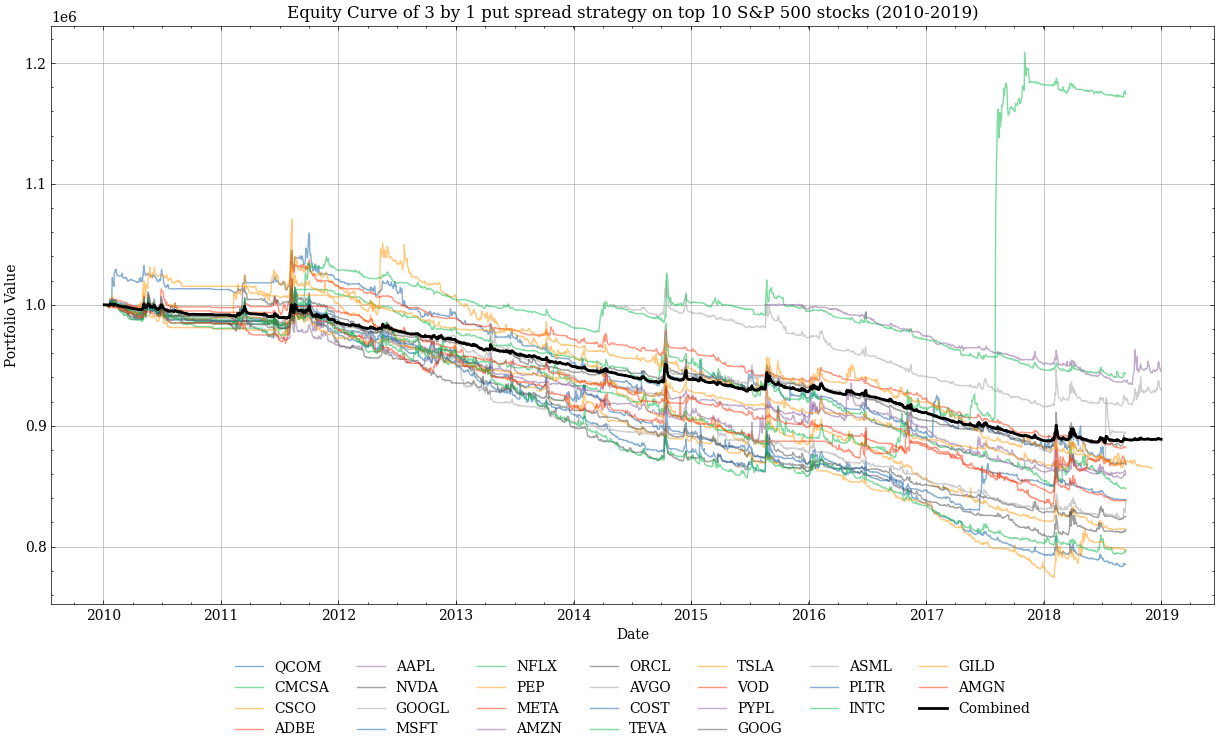

In [9]:
start = "2010-01-01"
end   = "2019-01-01"

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("default")
plt.style.use('science')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

equity_combined = data_manager.combined_outputs['multi_stock']['equity']
equity_combined.index = pd.to_datetime(equity_combined.index)
equity_combined = equity_combined.loc[start_dt:end_dt]

fig, ax1 = plt.subplots(figsize=(15, 7.5))


for tick in universe.ticks:
    equity_tick = data_manager.outputs[tick]['equity']
    equity_tick.index = pd.to_datetime(equity_tick.index)
    equity_tick = equity_tick.loc[start_dt:end_dt]
    ax1.plot(equity_tick, label=f"{tick}", alpha=0.5)

ax1.plot(equity_combined, label="Combined", color='black', linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value")
ax1.grid(True)
handles, labels = ax1.get_legend_handles_labels()
ncols = int(np.ceil(len(labels) / 4))
ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=ncols, frameon=False)
plt.title("Equity Curve of 3 by 1 put spread strategy on top 10 S&P 500 stocks (2010-2019)")
plt.show()

In [7]:
import pickle
with open('tmp/pkl/2_by_1_top_10.pkl', 'wb') as f:
    pickle.dump(data_manager, f)